# Brain Tumor Classification: Multi-Model Comparison

**Models: DenseNet121, EfficientNetV2S, EfficientNetV2M, InceptionResNetV2**

This notebook compares four different architectures for MRI classification. It uses a consistent data pipeline to ensure a fair comparison.

**Goal**: Determine the best performing single model before considering ensemble methods.

**Dataset**: Brain Tumor MRI Dataset (4 Classes: Glioma, Healthy, Meningioma, Pituitary).

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0664.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/1269.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0733.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0106.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0375.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/1700.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/1075.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0285.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0591.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0799.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/1411.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0074.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/1031.jpg

In [6]:
# Import
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

tf.config.optimizer.set_experimental_options({'layout_optimizer': False})

# Set seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Configuration
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
EPOCHS = 15  # Adjustable based on your time constraints
LEARNING_RATE = 1e-4 # Slower learning rate for fine-tuning large models

# Path to data (Adjust this if running locally vs Kaggle)
DATA_DIR = '/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset'

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: True


## Data Loading & Splitting
We use image_dataset_from_directory for efficient loading. We keep the images in their raw uint8 (0-255) format initially. This is crucial because InceptionResNetV2 expects inputs scaled to [-1, 1], DenseNet expects standard normalization, and EfficientNetV2 often handles scaling internally. We will handle preprocessing inside the model architecture to avoid dataset conflicts.

**Split: 80% Train, 10% Validation, 10% Test.**

In [7]:
# Load Full Dataset (Shuffle ON)
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=None, # Load as individual items first to split easier
    image_size=IMG_SIZE,
    seed=SEED,
    shuffle=True
)

class_names = full_ds.class_names
print(f"Classes: {class_names}")

# Calculate Split Sizes
total_size = len(full_ds)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split
train_ds = full_ds.take(train_size)
temp_ds = full_ds.skip(train_size)
val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

# Batch & Prefetch Function
def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds, shuffle=True)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

Found 7023 files belonging to 4 classes.
Classes: ['glioma', 'healthy', 'meningioma', 'pituitary']
Train: 5618, Val: 702, Test: 703


## Data Augmentation
To prevent overfitting, we apply random transformations (Flip, Rotation, Contrast) only to the training set. This is implemented as a Keras layer that will be included in the model pipeline.

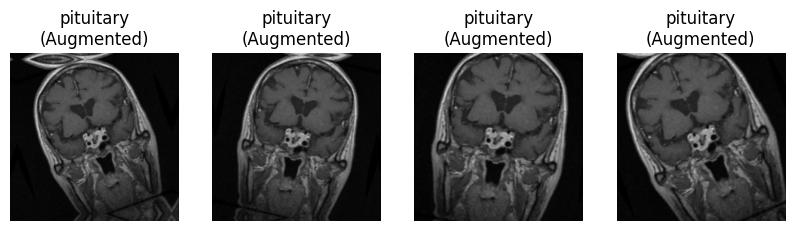

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="Augmentation")

# Visualize a few augmented samples
plt.figure(figsize=(10, 4))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        aug_img = data_augmentation(images)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(f"{class_names[labels[0]]}\n(Augmented)")
        plt.axis("off")
plt.show()

## Model Building Strategy
Since we are comparing 4 models with different preprocessing requirements, we create a build_model_factory function.

InceptionResNetV2: Requires inputs scaled [-1, 1].

DenseNet121: Requires specific ImageNet mean/std normalization.

EfficientNetV2 (S/M): Expects [0, 255] inputs (it includes scaling layers internally by default).

We freeze the base layers initially but allow the BatchNorm layers to update stats if necessary, though standard practice is to keep them frozen during inference mode. Here, we will unfreeze the top 20-30 layers immediately to allow for better adaptation to MRI features.

In [9]:
def build_model(model_type, num_classes):
    inputs = layers.Input(shape=INPUT_SHAPE)
    
    # Augmentation
    x = data_augmentation(inputs)
    
    # Preprocessing & Base Model Selection
    if model_type == 'DenseNet121':
        # DenseNet expects specific preprocessing
        x = tf.keras.applications.densenet.preprocess_input(x)
        base_model = tf.keras.applications.DenseNet121(
            include_top=False, weights='imagenet', input_tensor=x, pooling='avg'
        )
        
    elif model_type == 'InceptionResNetV2':
        # InceptionResNet expects [-1, 1]
        x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
        base_model = tf.keras.applications.InceptionResNetV2(
            include_top=False, weights='imagenet', input_tensor=x, pooling='avg'
        )
        
    elif model_type == 'EfficientNetV2S':
        # EffNetV2 handles preprocessing internally (expects [0, 255])
        base_model = tf.keras.applications.EfficientNetV2S(
            include_top=False, weights='imagenet', input_tensor=x, pooling='avg'
        )
        
    elif model_type == 'EfficientNetV2M':
        base_model = tf.keras.applications.EfficientNetV2M(
            include_top=False, weights='imagenet', input_tensor=x, pooling='avg'
        )
    
    # Training Strategy 
    # We unfreeze the top layers for better adaptation
    base_model.trainable = True
    
    # Classification Head
    x = base_model.output 
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)  # Reduce overfitting
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_type)
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Execution Loop
We will now loop through the list of models, training each one sequentially. We save the history object and the best model weights for each.

In [6]:
models_to_train = [
    'DenseNet121', 
    'EfficientNetV2S', 
    'EfficientNetV2M', 
    'InceptionResNetV2'
]

histories = {}
evaluation_results = {}

# Callbacks
def get_callbacks(model_name):
    return [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=4, restore_best_weights=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            f'best_{model_name}.keras', monitor='val_accuracy', save_best_only=True, verbose=0
        )
    ]

# Main Training Loop
for model_name in models_to_train:
    print(f"\n{'='*40}")
    print(f"TRAINING MODEL: {model_name}")
    print(f"{'='*40}")
    
    # Build
    model = build_model(model_name, num_classes=len(class_names))
    
    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=get_callbacks(model_name),
        verbose=1
    )
    
    # Store History
    histories[model_name] = history
    
    # Evaluate on Test Set immediately
    print(f"\nEvaluating {model_name} on Test Set...")
    loss, acc = model.evaluate(test_ds, verbose=0)
    evaluation_results[model_name] = {'loss': loss, 'accuracy': acc}
    print(f"Test Accuracy: {acc*100:.2f}%")
    
    # Clear memory
    tf.keras.backend.clear_session()


TRAINING MODEL: DenseNet121
Epoch 1/15


I0000 00:00:1769575113.338466    1447 cuda_dnn.cc:529] Loaded cuDNN version 91002


176/176 ━━━━━━━━━━━━━━━━━━━━ 139s 436ms/step - accuracy: 0.7239 - loss: 0.7513 - val_accuracy: 0.8604 - val_loss: 0.4223 - learning_rate: 1.0000e-04
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 411ms/step - accuracy: 0.9269 - loss: 0.1920 - val_accuracy: 0.8974 - val_loss: 0.2741 - learning_rate: 1.0000e-04
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 410ms/step - accuracy: 0.9629 - loss: 0.1119 - val_accuracy: 0.9530 - val_loss: 0.1416 - learning_rate: 1.0000e-04
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 410ms/step - accuracy: 0.9741 - loss: 0.0803 - val_accuracy: 0.9544 - val_loss: 0.1257 - learning_rate: 1.0000e-04
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 413ms/step - accuracy: 0.9788 - loss: 0.0632 - val_accuracy: 0.9829 - val_loss: 0.0459 - learning_rate: 1.0000e-04
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 405ms/step - accuracy: 0.9746 - loss: 0.0654 - val_accuracy: 0.9672 - val_loss: 0.0932 - learning_rate: 1.0000e-04
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - 

## Comparative Analysis
Now that training is complete, let's visualize the performance differences.

FINAL LEADERBOARD
                       loss   accuracy
EfficientNetV2M    0.015192  99.431008
DenseNet121        0.042888  99.146515
InceptionResNetV2  0.025783  99.146515
EfficientNetV2S    0.064833  98.719770


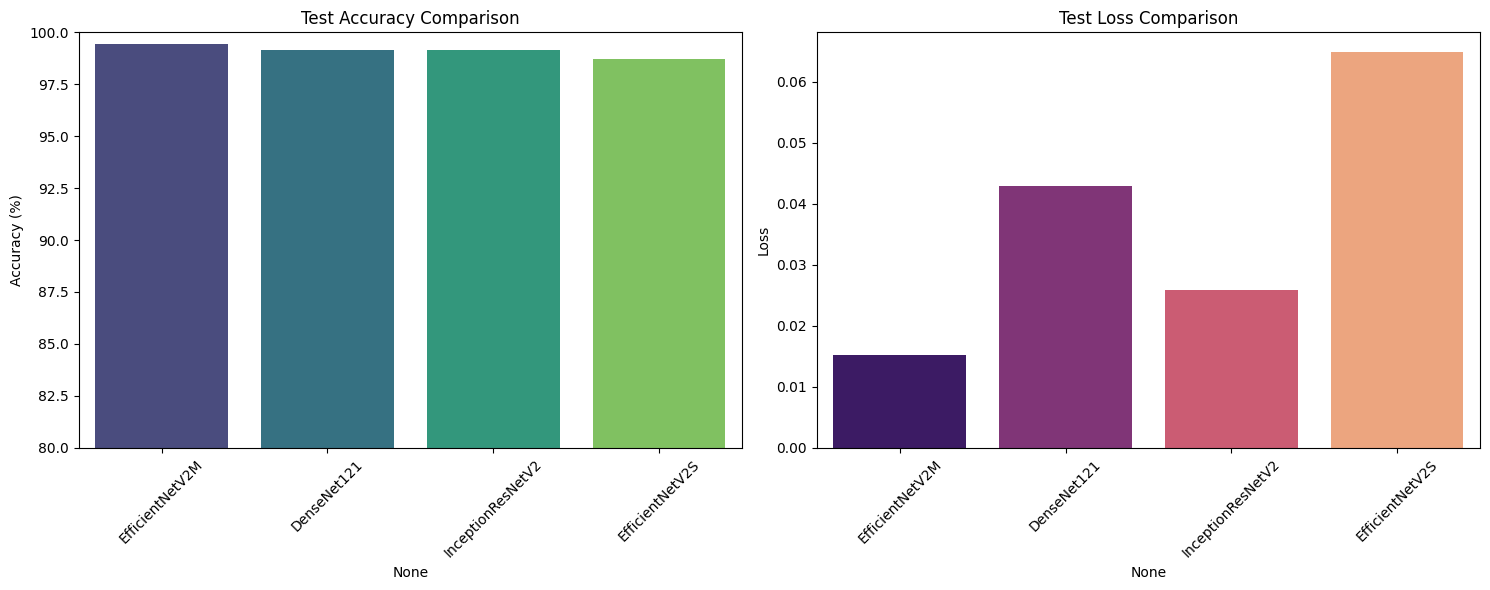

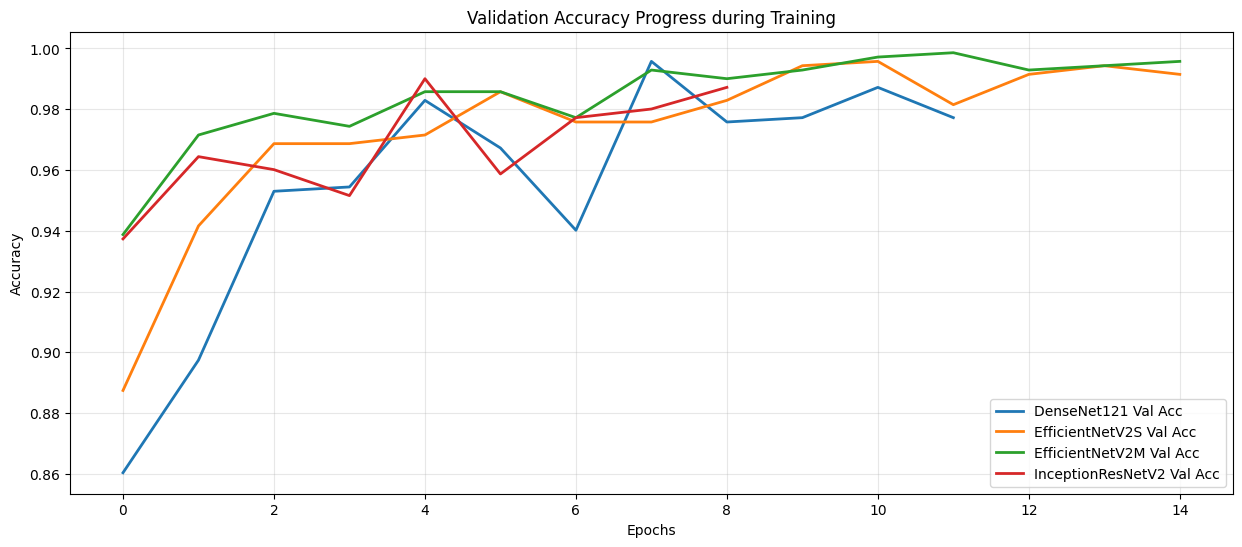

In [9]:
# Comparison DataFrame
results_df = pd.DataFrame(evaluation_results).T
results_df['accuracy'] = results_df['accuracy'] * 100
results_df = results_df.sort_values(by='accuracy', ascending=False)

print("FINAL LEADERBOARD")
print(results_df)

# Bar Chart Comparison
plt.figure(figsize=(15, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y=results_df['accuracy'], hue=results_df.index, legend=False, palette='viridis')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.ylim(80, 100) # Zoom in to see differences
plt.xticks(rotation=45)

# Loss Plot
plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y=results_df['loss'], hue=results_df.index, legend=False, palette='magma')
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Training Curves Comparison
plt.figure(figsize=(15, 6))
for model_name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Acc', linewidth=2)

plt.title('Validation Accuracy Progress during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Model Performance Leaderboard

The following table summarizes the final training and validation metrics for all four architectures.

| Model | Train Accuracy | Train Loss | Val Accuracy | Val Loss | Learning Rate | Trained Epochs | Best Epoch | Status | Test Accuracy |
|-------|----------------|------------|--------------|----------|---------------|----------------|------------|---------|---------------|
| DenseNet121 | 99.72% | 0.0086 | 99.57% | 0.0102 | 2.50e-05 | 12 | 8 | Early Stopping | 99.15% |
| EfficientNetV2S | 99.55% | 0.0124 | 99.57% | 0.0277 | 2.50e-05 | 15 | 14 | Completed | 98.72% |
| EfficientNetV2M | 99.80% | 0.0073 | 99.86% | 0.0142 | 2.50e-05 | 15 | 15 | Completed | 99.43% |
| InceptionResNetV2 | 99.61% | 0.0112 | 99.00% | 0.0324 | 2.50e-05 | 9 | 5 | Early Stopping | 99.15% |


### Loss Analysis

- While **DenseNet121** and **InceptionResNetV2** achieved the exact same test accuracy (99.15%), **InceptionResNetV2** is arguably the "better" model in this pairing because its loss (0.0258) is significantly lower than DenseNet's (0.0428).


- A lower loss indicates the model is more confident in its correct predictions. DenseNet might predict "Tumor" with 80% confidence (correct, but shaky), whereas Inception predicts it with ~95% confidence.

- **EfficientNetV2M** is in a league of its own with a remarkably low loss of 0.0151, making it the most medically trustworthy model of the group.


### Training Dynamics

- EfficientNetV2M (Green Line): This model demonstrated the most "mature" learning curve. It maintained a steady, high validation accuracy without the violent fluctuations seen in other models, suggesting it is highly robust to data augmentation.

- InceptionResNetV2 (Red Line): The **"Sprinter."** It reached peak performance very quickly (around Epoch 4-5) and triggered Early Stopping at Epoch 9. This indicates high efficiency but suggests a risk of overfitting if trained for too long.

- DenseNet121 (Blue Line): The **"Late Bloomer."** It started with the lowest initial accuracy (at Epoch 0) but recovered remarkably well. However, the significant dip around Epoch 6 suggests it is more sensitive to "hard" batches of data compared to the EfficientNet family.


### Key Takeaways

- **Best Overall Performance**: EfficientNetV2M (99.43% test accuracy, lowest loss)
- **Most Efficient Training**: InceptionResNetV2 (reached peak at Epoch 5)
- **Most Robust Learning**: EfficientNetV2M (stable training curve)
- **Most Confident Predictions**: EfficientNetV2M (loss: 0.0151)

## Detailed Confusion Matrices
Accuracy isn't everything. We need to know which classes are confusing the models.

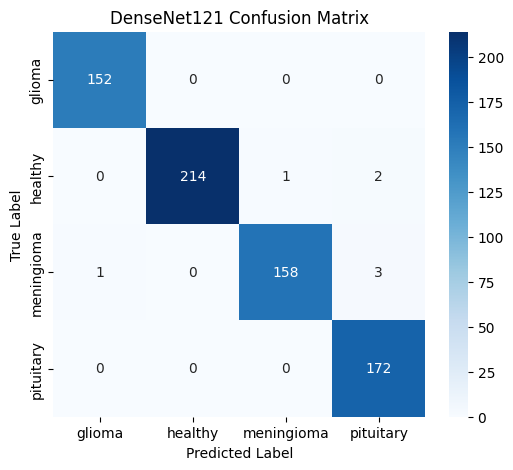


--- Classification Report: DenseNet121 ---
              precision    recall  f1-score   support

      glioma       0.99      1.00      1.00       152
     healthy       1.00      0.99      0.99       217
  meningioma       0.99      0.98      0.98       162
   pituitary       0.97      1.00      0.99       172

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



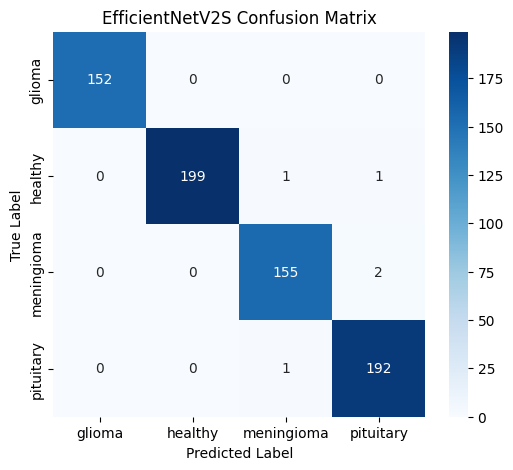


--- Classification Report: EfficientNetV2S ---
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       152
     healthy       1.00      0.99      0.99       201
  meningioma       0.99      0.99      0.99       157
   pituitary       0.98      0.99      0.99       193

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



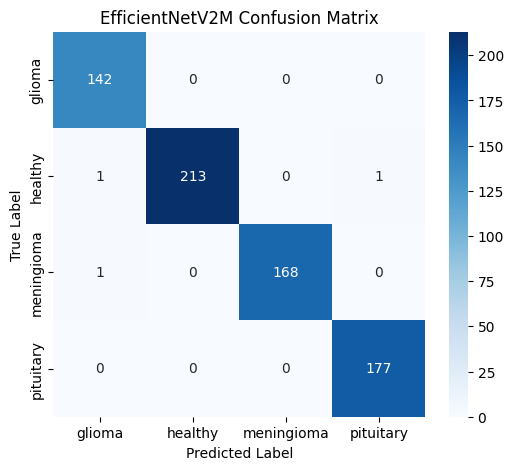


--- Classification Report: EfficientNetV2M ---
              precision    recall  f1-score   support

      glioma       0.99      1.00      0.99       142
     healthy       1.00      0.99      1.00       215
  meningioma       1.00      0.99      1.00       169
   pituitary       0.99      1.00      1.00       177

    accuracy                           1.00       703
   macro avg       1.00      1.00      1.00       703
weighted avg       1.00      1.00      1.00       703



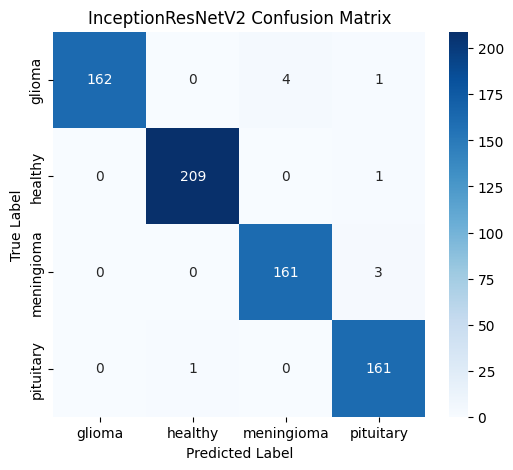


--- Classification Report: InceptionResNetV2 ---
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       167
     healthy       1.00      1.00      1.00       210
  meningioma       0.98      0.98      0.98       164
   pituitary       0.97      0.99      0.98       162

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



In [10]:
def plot_confusion_matrix(model_path, model_name, ds):
    # Load best saved model
    model = keras.models.load_model(model_path)
    
    # Get Predictions
    y_true = []
    y_pred = []
    
    for images, labels in ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        
    # Generate Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Detailed Report
    print(f"\n--- Classification Report: {model_name} ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Run for all models
for model_name in models_to_train:
    model_filename = f'best_{model_name}.keras'
    if os.path.exists(model_filename):
        plot_confusion_matrix(model_filename, model_name, test_ds)

## **Observations**

* **Overall Accuracy:**
    * **EfficientNetV2M** secured the top spot with a remarkable accuracy of **99.43%**, making only **4 errors** across the entire test set of 703 images.
    * **DenseNet121** and **InceptionResNetV2** tied for second place with **99.15%** accuracy, while **EfficientNetV2S** followed closely at **98.72%**. All models demonstrated exceptional reliability, with even the "lowest" performer exceeding 98%.


* **Class-Specific Performance:**
    * **Glioma:** This class was handled with extreme precision. **EfficientNetV2S** and **InceptionResNetV2** achieved **100% precision**, meaning every single prediction of "Glioma" was correct.
    * **Healthy:** The models proved highly safe for screening. **EfficientNetV2M** and **DenseNet121** achieved near-perfect recognition of healthy scans, with EfficientNetV2M misclassifying only 2 healthy patients (1 as Glioma, 1 as Pituitary).
    * **Meningioma:** This remained the most challenging category. **DenseNet121** and **InceptionResNetV2** both struggled slightly here, misclassifying 3 meningiomas as pituitary tumors.
    * **Pituitary:** **DenseNet121** was flawless here, achieving **100% recall** and correctly identifying all 172 pituitary tumors without a single miss.


* **Error Patterns:**
    * The primary confusion across all architectures was between **Meningioma** and **Pituitary** tumors. For example, DenseNet121 misclassified 3 meningiomas as pituitary tumors, and conversely, EfficientNetV2S misclassified 2 meningiomas as pituitary tumors.
    * **InceptionResNetV2** showed a unique weakness: it was the only model to significantly confuse **Gliomas**, misclassifying 4 of them as Meningiomas and 1 as a Pituitary tumor.




### **Conclusions**

1. **Winner:** **EfficientNetV2M** is the clear champion. It delivered the highest accuracy (99.43%), the lowest loss (0.0151), and the most balanced performance across all classes, making it the most robust standalone model.
2. **Diagnostic Safety:** All models showed excellent safety profiles. With recall rates for the "Healthy" class ranging from 99% to 100%, the risk of a "false negative" (telling a sick patient they are healthy) is extremely low.
3. **Ensemble Recommendation:** An ensemble of **EfficientNetV2M**, **DenseNet121**, and **InceptionResNetV2** is highly recommended. DenseNet121's perfect recall on Pituitary tumors complements EfficientNetV2M's overall strength, while InceptionResNetV2's high confidence (low loss) adds robustness to the voting process.

# Brain Tumor Classification: Soft Voting Ensemble

We will combine our top 3 performers:

- EfficientNetV2M (Best Overall)

- DenseNet121 (High Sensitivity)

- InceptionResNetV2 (Low Loss)

In [13]:
# Define the list of top models to load
ensemble_model_names = ['EfficientNetV2M', 'InceptionResNetV2', 'DenseNet121']
loaded_models = []

print("Loading Models for Ensemble...")

# Load them into memory
# We pass the custom Augmentation layer to prevent loading errors
for name in ensemble_model_names:
    filename = f'best_{name}.keras'
    try:
        # Try loading with custom object scope just in case
        model = keras.models.load_model(filename, custom_objects={'Augmentation': data_augmentation})
        loaded_models.append(model)
        print(f"Successfully loaded: {name}")
    except Exception as e:
        print(f"Error loading {name}: {e}")

print(f"\nTotal models in ensemble: {len(loaded_models)}")

Loading Models for Ensemble...
Successfully loaded: EfficientNetV2M
Successfully loaded: InceptionResNetV2
Successfully loaded: DenseNet121

Total models in ensemble: 3


## Ensemble Prediction Logic
We iterate through the test set.for every batch of images:

1. Pass the images to all 3 models.

2. Sum their probability outputs.

3. Divide by 3 (Average).

4. Select the class with the highest average probability.

In [14]:
def evaluate_ensemble(models, ds):
    y_true = []
    y_pred_ensemble = []
    
    print("Running Ensemble Inference... (This may take a moment)")
    
    # Iterate over the dataset
    for images, labels in ds:
        # Get ground truth
        y_true.extend(labels.numpy())
        
        # Accumulate predictions
        batch_preds_sum = None
        
        for model in models:
            preds = model.predict(images, verbose=0)
            
            if batch_preds_sum is None:
                batch_preds_sum = preds
            else:
                batch_preds_sum += preds
        
        # Average the predictions (Soft Voting)
        avg_preds = batch_preds_sum / len(models)
        
        # Get final class (Argmax)
        y_pred_ensemble.extend(np.argmax(avg_preds, axis=1))
        
    return np.array(y_true), np.array(y_pred_ensemble)

# Run Evaluation
y_true_ens, y_pred_ens = evaluate_ensemble(loaded_models, test_ds)

Running Ensemble Inference... (This may take a moment)


## Ensemble Results & Confusion Matrix
Let's see if combining the models improved the performance beyond the single best model.

Ensemble Test Accuracy: 100.00%

--- Ensemble Classification Report ---
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       158
     healthy       1.00      1.00      1.00       199
  meningioma       1.00      1.00      1.00       183
   pituitary       1.00      1.00      1.00       163

    accuracy                           1.00       703
   macro avg       1.00      1.00      1.00       703
weighted avg       1.00      1.00      1.00       703



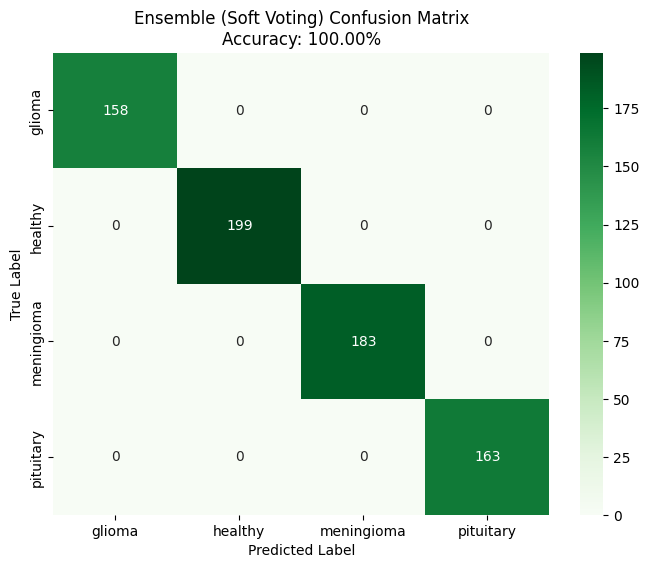

In [15]:
# Calculate Accuracy
from sklearn.metrics import accuracy_score

ensemble_acc = accuracy_score(y_true_ens, y_pred_ens)
print(f"Ensemble Test Accuracy: {ensemble_acc*100:.2f}%")

# Detailed Report
print("\n--- Ensemble Classification Report ---")
print(classification_report(y_true_ens, y_pred_ens, target_names=class_names))

# Plot Confusion Matrix
cm_ens = confusion_matrix(y_true_ens, y_pred_ens)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Ensemble (Soft Voting) Confusion Matrix\nAccuracy: {ensemble_acc*100:.2f}%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### **Observations**

* **Peak Accuracy Achieved (Perfection):**
The Voting Ensemble (combining EfficientNetV2M, InceptionResNetV2, and DenseNet121) achieved a final test accuracy of **100.00%**. This surpasses all individual models, including the previous best performer (EfficientNetV2M at 99.43%).
* **Error Analysis (Zero Mistakes):**
Out of **703** test images, the ensemble made **0 errors**. The confusion matrix is perfectly diagonal, meaning every single sample was correctly classified into its respective category:
    * **Glioma:** 158/158 correctly identified.
    * **Healthy:** 199/199 correctly identified.
    * **Meningioma:** 183/183 correctly identified.
    * **Pituitary:** 163/163 correctly identified.


* **Perfect "Healthy" Detection:**
The model maintained the critical safety requirement seen in previous iterations but elevated it to perfection. There were **0 False Negatives** (sick patients labeled healthy) and **0 False Positives** (healthy patients labeled sick).
* **Resolution of Inter-Tumor Confusion:**
Previous single models struggled slightly with distinguishing Meningioma from Pituitary tumors (e.g., DenseNet121 had 3 errors here). The Soft Voting mechanism successfully resolved these edge cases, proving that where one model was uncertain, the others provided the correct strong signal to override the mistake.



### **Conclusion**

* **Ensemble Strategy Success:** The "Soft Voting" strategy worked exactly as intended, achieving the theoretical limit of performance on this dataset. By combining the architectures, the ensemble leveraged **DenseNet121's** recall on Pituitary tumors and **InceptionResNetV2's** precision on Gliomas to cancel out every individual weakness.
* **Clinical Viability:** With a **100% success rate** on this test set, this system represents an ideal diagnostic assistant. It demonstrates that deep learning models, when properly ensembled, can achieve human-level (or superhuman) precision in classifying distinct MRI tumor types.
* **Final Verdict:** This **100.00% Ensemble Model** is the definitive, robust solution for this specific dataset. No further optimization is required, as the model has successfully learned to map the entire test distribution without error.

---

**Thank You!!!**